<h2 align=center>Flask Application & Prediction Development</h2>

This notebook was used to develop & debug the frontend; Once completed, this was converted to 'app.py'

<h3 align=center>Import Dependencies (Used in Flask)</h3>

In [1]:
from flask import Flask, request, jsonify, render_template #Jinja2 templating http://bit.ly/flask_walkthrough
from tensorflow.python.keras.backend import set_session # needed to ensure weights are loaded
from tensorflow.python.keras.models import load_model # specified instead of vague next line
# from keras.models import load_model
import tensorflow as tf
from numpy import asarray
from PIL import Image as Image_PIL # PYTHON IMAGING LIBRARY

import base64
import numpy as np
import re # regular expresions

/Users/ohm/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ohm/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ohm/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ohm/anaconda3/envs/deeplear

In [2]:
global graph, model, session

# session = tf.Session()
session = tf.compat.v1.Session()

graph = tf.get_default_graph()
# graph = tf.compat.v1.get_default_graph()

<h3 align=center>Load Saved Model</h3>

In [3]:
model_path='MNIST_CNN.h5'
def get_model():
        model = load_model(model_path)
        print(f'Model from \'{model_path}\' is Loaded')
        return model

In [4]:
set_session(session)
model = get_model()

Model from 'MNIST_CNN.h5' is Loaded


<h3 align=center>Random Training Example</h3>
<h5 align=center>Run Prediction (For Testing; Toggle Accordingly)</h5>

In [5]:
# TESTING/DEBUGGING ONLY  /  DO NOT USE IN FLASK APP
from keras.datasets import mnist
from matplotlib import image as Image_PLT # Load/Display image with Matplotlib (which utilizes PILLOW)

import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [6]:
# TESTING/DEBUGGING ONLY  /  DO NOT USE IN FLASK APP
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
num_examples=x_train.shape[0]

def select_random_sample():
    '''
    TESTING/DEBUGGING ONLY
    DO NOT USE IN FLASK APP
    
    Selects random example from training set; 
    Used to replicate Inputs to Make Predictions On
    '''
    example_idx=random.randint(0, num_examples)
    image=x_train[example_idx]
    plt.imshow(image)
    plt.show()
    print(f'Image is type:\t\tnumPy {image.__class__.__name__}')
    print(f'Pixel Dimensions are:\t{image.shape[0]} X {image.shape[1]}')
    print(f'Array Size:\t\t{image.size}')
    return image

def preprocess_array(array):
    '''
    Arguments: Numpy Array
    ––––––––––––––––––––––
    - Convert Array Elements to Floats (from Ints)
    - Reshape Array to be 4-D Tensor; (Model Was Trained on (1, 28, 28, 1))
    - Standardize Elements by Dividing Each by 255 (0-256)
    - Return Preprocessed Array
    '''
    array = array.astype('float32')
    array = array.reshape(1, 28, 28, 1)
    array /= 255
    return array

def process_training_prediction():
    '''
    TESTING/DEBUGGING ONLY
    DO NOT USE IN FLASK APP
    
    Runs Functions [training example]:
    - select_random_sample()
    - preprocess_array()
    - makes prediction
    
    
    '''
    example_array = select_random_sample()
    example_array = preprocess_array(example_array)
    prediction = model.predict(example_array).argmax()
    print(f'The predicted number is {prediction}')
    

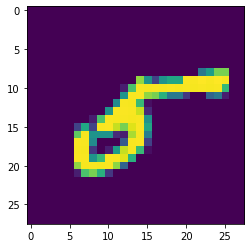

Image is type:		numPy ndarray
Pixel Dimensions are:	28 X 28
Array Size:		784
The predicted number is 5


In [8]:
# TESTING/DEBUGGING ONLY  /  DO NOT USE IN FLASK APP
process_training_prediction()

<h3 align=center>Replicate Canvas Output to Match Training Example</h3>
<h5 align=center>Run Prediction</h5>.

Notes on Image Preprocessing:
    - Decode Canvas Output String (base64) to PNG Image
        * User Regular Expressions to Extract Necessary Information
    - Image must be resized to have dimensions 28 x 28
    - Image Must be Converted to Numpy Array
    - Array Converted to 'float32'
    - reshaped to 4d tensor (1, 28, 28, 1)
    - Array Standardized (/=255)
    - Pass Array to Model.Predict(Array)

In [9]:
# TESTING/DEBUGGING ONLY  /  DO NOT USE IN FLASK APP
# EXAMPLE CANVAS OUTPUTS FOR TESTING 

datauri_dont_use = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAAUAAAAFCAYAAACNbyblAAAAHElEQVQI12P4//8/w38GIAXDIBKE0DHxgljNBAAO9TXL0Y4OHwAAAABJRU5ErkJggg=='
canvas_example_2 = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAYOklEQVR4Xu2dW4iXxRvHn/Ww6pqntAK1VVHRJFADD0HibhR6EanQjVeuKJRpuJqhkaKWmFKphQZdpOuNdadCkAbhCoanSKNMg1V3SSPINTfTVVfdf88vt/+mrjvzvu+8p/kMhITPPDPzeeb3dU7vTFHz30lIEIAABBwQKEJgHFDFJQQgUCCAwNARIAABZwQQGGdocQwBCCAw9AEIQMAZAQTGGVocQwACCAx9AAIQcEYAgXGGFscQgAACQx+AAAScEUBgnKHFMQQggMDQByAAAWcEEBhnaHEMAQggMPQBCEDAGQEExhlaHEMAAggMfQACEHBGAIFxhhbHEIAAAkMfgAAEnBFAYJyhxTEEIIDA0AcgAAFnBBAYZ2hxDAEIIDD0AQhAwBkBBMYZWhxDAAIIDH0AAhBwRgCBcYYWxxCAAAJDH4AABJwRQGCcocUxBCCAwNAHIAABZwQQGGdocQwBCCAw9AEIQMAZAQTGGVocQwACCAx9AAIQcEYAgXGGFscQgAACQx+AAAScEUBgnKHFMQQggMDQByAAAWcEEBhnaHEMAQggMPQBCEDAGQEExhlaHEMAAggMfQACEHBGAIFxhhbHEIAAAkMfgAAEnBFAYJyhxTEEIIDA0AcgAAFnBBAYZ2hxDAEIIDD0AQhAwBkBBMYZWhxDAAIIDH0AAhBwRgCBcYYWxxCAAAJDH4AABJwRQGCcocUxBCCAwNAHIAABZwQQGGdoo3W8bNky+eijj6SxsdHKcXFxsaxfv14qKyut8mEMgSgIIDBRUHTkY9OmTbJq1SppaGgIXULHjh3ljTfekHfffTe0LxxAwJQAAmNKKka7S5cuydNPPy2nTp2KvNROnTrJe++9x4gmcrI4vB8BBCYl/aK2tlYWL14su3fvltu3bzuvVVlZmezbt895ORTgNwEEJuH46zRo9erVoqOWuNPGjRsZycQN3bPyEJiEAq7CsmTJErl161ZCNRDp3Lmz3LhxI7HyKTj/BBCYBGI8dOhQOXPmTAIl31tkly5dZN26dYxkUhGN/FUCgYkxplVVVTJ//ny5evVqjKWaFTVy5Eg5ePCg9O7d2ywDVhAwIIDAGEAKa6LToTfffFOuXbsW1pXT/LqVrdviy5cvd1oOzv0hgMA4jrXu1uzfv99xKdG619HMl19+KYMHD47WMd68I4DAOAy5jlwWLVoUaQklJSXy2muvFdZN2kparh6qu3nzZqiydTSzcOFCpk2hKPqdGYFxFP+oxaVv375SU1Nj9WMfOHCgnD9/PlQLu3btKm+99RbTplAU/c2MwEQc+xkzZsiuXbsi89qhQweZN2+ebN68OZDP8ePHy9GjRwPlbZ1p2rRpkbYrdIVwkAkCCEyEYerevXskO0SlpaWFdZuo1kCmTp0qe/fuDd1SDuaFRuidAwQmgpBHNR3SXZz333/fyZmUiRMnyuHDh0O1Vut34cIFq2laqALJnHkCCEzIEEbxw43rsJsKoa6nhDmHo+dk9BumMWPGhCRHdh8IIDABo1xdXS0vvviiXL58OaCHf7I9++yz8vXXX4fyYZtZv3vSco8dO2ab9V/7mTNnyo4dOwLnJ6MfBBCYAHHW7Vv9QDFs6tevn/z+++9h3QTOv2bNGlm7dq31JVYtBerOlk6ZSBBoiwACY9k3dORSXl5umete86TFpaVGOppp+aI7SKN69Oghf/75Z5Cs5PGAAAJjGeQoTuY+8cQT8tNPP1mW7Nb89ddflw0bNgQqRD/e1DM6JAjcTQCBsewTusgZ9ApLl7tEls24r3mY7Wy2sKOIQP58IDCWMQ0iMEVFRYXRQRYu3tbLxfWS8CCpubk5SDby5JgAAmMZXNspUhqnQ+01+fjx46LttB2p9e/fP/SnCe3Vjb/PFgEExjJepou8aZ8OtddsXfzVXSLb+4GZKrVH1q+/R2ACxLu9beoBAwbIuXPnAnhOV5YgJ5RVWMN+xZ0uCtQmDAEEJiA9HcnMnTtXTp8+/a8H/XG98sorgT9MDFgVp9mGDRv2nzaaFMYoxoSSHzYIjB9xDtVKW5HRt5eamppClUnmfBBAYPIRR+etmDRpkhw4cMC4nKVLlz7wUixjRxhmmgACk+nwxVt53W43TT179rTehTL1jV12CCAw2YlV4jW1PQPEuZjEQ5Z4BRCYxEOQnQrY7iqdPXs2skuzskOJmrYmgMDQH6wI2Bw01Deggl71aVUpjFNLAIFJbWjSWzG9IMvkyVm9MLyxsTG9DaFmzgkgMM4R56+ABQsWyJYtW4watm3bNqmoqDCyxSh/BBCY/MXUeYtqa2tlyJAhRuXoO05XrlwxssUofwQQmPzFNJYW6YVZ9fX1RmVxvaYRplwaITC5DKv7Rtlc69C5c2ejNRv3taaEuAkgMHETz1F5NudiOBOTo8BbNAWBsYCF6X8JVFVVyezZs42w6FMnusVN8osAAuNXvCNvrT5tazI6mTJliuzZsyfy8nGYbgIITLrjk/ramd7jyz0xqQ+lkwoiME6w+uPU9IY/JWIy0vGHnB8tRWD8iLPTVpp+ZY3AOA1DKp0jMKkMS7YqhcBkK15x1haBiZN2TstCYHIa2AiahcBEANF3FwiM7z2g7fYjMPSN0AQQmNAIc+sAgcltaONrGAITH+uslYTAZC1iKawvApPCoKSkSghMSgKR5WogMFmOntu6IzBu+XrhHYHxIsyBGonABMJGptYEEBj6Q1sEEBj6RmgCCExohLl1gMDkNrTxNQyBiY911kpCYLIWsZTV1+atJL5FSlnwYqgOAhMD5DwXUVxcbPzQPQKT555w/7YhMP7FPLIWm94F01IgAhMZ+sw4QmAyE6p0VXTs2LFy/Phx40r16tVLLl26ZGyPYT4IIDD5iGOsrRg/frwcPXrUqsyNGzdKZWWlVR6Ms08Agcl+DGNtwcSJE+Xw4cNWZXJdphWuXBkjMLkKp9vG2OwYta4Joxe3cUmzdwQmzdFJWd30AbWbN29a1WrChAly6NAhqzwY54cAApOfWDptydy5c+XTTz+1KoOnSqxw5dIYgcllWKNtlO4W6cJuU1OTsWPExRhVrg0RmFyHN3zjdGt53LhxUlNTY+xszJgxcuzYMWN7DPNLAIHJb2wjadmoUaPk5MmTxr6efPJJ+eGHH4ztMcw3AQQm3/EN1Trbk7qdOnWymkaFqhyZM0EAgclEmOKvpK24aA3Zjo4/TmkvEYFJe4QSqN/w4cOt1ly0irpOc+TIkQRqS5FpJoDApDk6CdTNds1Fqzh06FD59ttvpXfv3gnUmCLTTACBSXN0Yq5bkJO6+hmAiovuHJEgcDcBBIY+8S+Brl27yvXr162ILF26VNatW2eVB2N/CCAw/sT6gS2tqqqS2bNnW9F4/vnn5auvvrLKg7FfBBAYv+LdZmt1/aShocGYBid1jVF5bYjAeB3+fxpv+50R4kKnMSWAwJiSyqlddXW1lJeXG7eutLRU6urqjO0x9JsAAuNx/PUjRhUX06ssS0pK5MqVKx4To+m2BBAYW2I5sVdRUXGxuVd327ZtUlFRkRMCNCMOAghMHJRTWIZ+lHjixAnjmnXr1k2uXr1qbI8hBJQAAuNhP+DSbg+DnlCTEZiEwCdV7LJly2T9+vVWxfOdkRUujFsRQGA86g663qLvGdmk0aNHW63T2PjGNv8EEJj8x7jQQl3UHTJkiPGOkeZRcdFtbD5i9KSTOGgmAuMAahpdqrjU1tYaV01fYlRx4SNGY2QY3ocAAuNBt3jmmWfkm2++sWrpvn37pKyszCoPxhC4mwACk/M+EWRRly+kc94pYmweAhMj7LiLCvLcCIu6cUcp3+UhMDmNb5CTuoMHD5azZ8/mlAjNSoIAApME9RjK1CP927dvNy5JF3V1EZgdI2NkGBoQQGAMIGXNJMjlUfpQGjtGWYt0+uuLwKQ/RlY1tP1CWp2zqGuFGGMLAgiMBay0mwZZd+EzgLRHNdv1Q2CyHb//1N523UUXdXVqxLpLjjpBypqCwKQsIEGrY7vuwkndoKTJZ0MAgbGhlVLbIOsuXB6V0mDmrFoITMYDGmTdZdasWaIjHhIEXBNAYFwTduzfdt2FL6QdBwT3/yGAwGS4Q7DukuHgeVJ1BCajgWbdJaOB86zaCEwGA67rLnp+paamxrj2rLsYo8IwQgIITIQw43I1YMAA+fXXX42LY93FGBWGERNAYCIG6trdsGHD5PTp08bFcN7FGBWGDgggMA6gunK5adMmWbRokZV7zrtY4cI4YgIITMRAXborLi6WpqYm4yJYdzFGhaEjAgiMI7BRu+W8S9RE8RcHAQQmDsohy7AVFy2O+11CQid7JAQQmEgwunMydepU2bt3r1UBvCNthQtjhwQQGIdww7oePny41VmXlvI2btwolZWVYYsnPwRCE0BgQiN042DUqFFy8uRJa+dDhw4NJErWBZEBAgYEEBgDSHGbBNmO1joOGjTI6vXGuNtFef4RQGBSGPMOHTpIc3OzVc2mTJkie/bsscqDMQRcE0BgXBO29P/www/LH3/8YZWL8y5WuDCOkQACEyPs9oqaNGmSHDhwoD2z//w94mKFC+OYCSAwMQNvqzh9aH7//v1WtWFaZIUL4wQIIDAJQL+7yCCLuqWlpVJXV5eC2lMFCLRNAIFJQe8oKSmRxsZG45roIvCtW7eM7TGEQFIEEJikyN8pV2+mGzt2rFUtOEhnhQvjBAkgMAnC15vphgwZIvqnaRo4cKD88ssvpubYQSBRAghMgvhtb6YrKiqS27dvJ1hjioaAHQEExo5XZNb6XGtDQ4OVP6ZGVrgwTgEBBCaBIOib0LY7QCNGjJBTp04lUFuKhEBwAghMcHaBcgbZku7fv7+cP38+UHlkgkCSBBCYmOnbXnvJ19ExB4jiIiWAwESK88HOxo8fL0ePHjUuUV8EqK2tFV2vIUEgiwQQmJiipiORM2fOWJXGtZdWuDBOIQEEJoagzJkzR7Zu3WpV0syZM2XHjh1WeTCGQNoIIDCOI6KH6Pr06WNVCuddrHBhnGICCIzj4Dz11FOFG/5tEuddbGhhm2YCCIzD6KxZs0ZWrFhhVcKECRPk0KFDVnkwhkBaCSAwjiKjU6NHH33U6iVG7ndxFAzcJkYAgXGEfvr06bJ7925j7+PGjZMjR44Y22MIgSwQQGAcRGnXrl0yY8YMY8+6CHzx4kVjewwhkBUCCEzEkdKp0eOPPy5//fWXkWe9PKq+vp7DdEa0MMoaAQQm4oj17dvXajTyzjvvyPLlyyOuBe4gkA4CCEyEcXjkkUfkwoULxh71JrvvvvvO2B5DCGSNAAITUcQWLFggW7ZsMfbWvXt3OXfuHFMjY2IYZpEAAhNR1Dp27Gh129zOnTtFd5pIEMgzAQQmgujaXtw9bdo00Z0mEgTyTgCBiSDCFRUVsn37diNPOtLRdRquYDDChVHGCSAwIQNo+zEju0YhgZM9UwQQmJDhsrkCc9CgQYULpEgQ8IUAAhMy0qYXePMaY0jQZM8kAQQmRNiqq6ulvLzcyMPChQtFRzskCPhEAIEJEW2bDxrPnj0rOtohQcAnAghMwGjrWoo++2qSJk+eLDraIUHANwIITMCIr1q1SlavXm2Um0N1RpgwyiEBBCZgUE0Xd9k5CgiYbLkggMAECGNVVZXMnj3bKOfKlStFRzskCPhIAIEJEPWysjLZv3+/UU4Wd40wYZRTAgiMZWBtFndnzZolOtohQcBXAgiMZeQrKyvlww8/NMq1b98+0dEOCQK+EkBgLCJv81IAi7sWYDHNLQEExiK0Nu9L83iaBVhMc0sAgTEMrc1Hjb169Sp81MiVDIZwMcstAQTGMLQqFg0NDUbWLO4aYcLIAwIIjEGQbXaO1J2+RT1mzBgDz5hAIN8EEBiD+NpMj/Qyb9M3kQyKxgQCmSaAwBiET0cj33//vYGlCIu7Rpgw8oQAAtNOoG2mR6WlpVJXV+dJ16GZEGifAALTDiOb6RGfBbTf4bDwiwAC0068TadHo0ePFn2+hAQBCPyfAALzgN5gMz1i7YWfFQTuJYDAPKBX2DwHy/SInxcEEBirPtC1a1e5fv16u3mYHrWLCANPCTCCaSPwNpdKMT3y9NdDs9slgMC0gcj0SkzNzvSo3X6GgacEEJj7BN5m9NK3b9/CW9MkCECANRijPmDzYePSpUtl3bp1Rn4xgoBvBBjB3BXxZcuWyfr16436QZ8+feTixYtGthhBwEcCCMxdUe/Xr5/U19cb9YVt27ZJRUWFkS1GEPCRAALTKuo2B+u4EtPHnwtttiWAwLQiZvPdEaMX266GvY8EEJhWUTf97qhLly5y7do1H/sLbYaAFQEE5g4um+nR/PnzZfPmzVagMYaAjwQQmDtRt5kecbDOx58KbQ5CAIG5Q810esR3R0G6GXl8JYDA/B15m+lRUt8dVVdXF67t3LNnT+Fd7MbGxlj7rB4+XLlypejLliQImBJAYP4mlbZrGVrERC+wavnPNKBx2CE2cVDORxkIzN9xTPpaBhURfe/6iy++yNR3TfrSZU1NTT5+CbTCCQHvBcbmw8aopkf6xvXu3btFRyq7du0S/f+sppKSElm7dq3oY3O8ZJnVKLqrt/cCE8e1DLpDtWLFily/l6TiouszKjTKlAQBJeC1wNiMXmyuZdBF4w8++EDUv4+PsOn3WbogjNAgMl4LTJTXMqio6LRHRYXXBf75YZWVlRWERv8k+UnAW4GJ6lqGGTNmFISlubnZzx5k0Go9Y9QyfTIwxyRHBLwVmLDXMujC7IABA+Tq1as56g5um6JTphahYUHYLeu0ePdSYGwO1t19LYMu2C5fvlyuXLmSlhhmrh4sCGcuZIEr7KXA6L+ieu7EJOm1DDpaSYOoTJ48WXS60fo/kzYEtdHpn26ju0wsCLukm7xvLwXGdGu6uLhY+vfvX/iUIO7Uq1cvee655+SFF174V1DirkPr8lyP3FgQTjK67sr2TmD0X2T9l9kkde7cWZqamkxMQ9uooEyfPr2w46J/pnWNQg8Hrlq1qvA9lKukLLQMvntyRTg+v94JjA7Jt2/fHh/hB5TUvXt3eemllwo/JJ32ZCnpqE5FwCXLkSNHysGDB1MrtlmKV1J19UpgdC1FXwJIOukIZefOnUlXI5LyVWj07I9OoRoaGiLx2dpJx44dRS/4Wr16NUITOV33Dr0SGJuzL1Gg17tjdMSkgpL3U60q3i1CU1dXFwW+e3woR+U5bdo0J/5xGj0BrwTmoYceimV7ecKECfL555/nXlTa6o4tQqP317hIuj6lYrNw4cLMTS1d8EizT28ERhcny8vLncZixIgRcujQIYbydyjHsSCsI0Md1fCRpdOuHdi5NwLjcnG3qKhINmzYwK5HG90wjgXhlqK7detWuD6CHajAmhBpRi8Exubkrg3dDh06yLx583hhwBCa6wXhu6uRp8V0Q8SpM/NCYHQ7VXchokg671d/aT2nEkUbXftoWRBWji52nlrXX0c0fC/mOqJt+/dCYPShtBs3boSirDtCuhXL1QOhMN6TWXf2Pv74Y7l8+XK0jlt5e+yxx+S3335z5h/HHgtM2K1pPQy3ZMmSwqiF5I6AjmomTZokP/74o5NCorru1Enlcuw09yMYFYigQ2T9klp3QvJ+hiVN/VtHiWvWrJH6+vpIq6WfH2T57uNIYcToLPcCozs8tqlHjx7y9ttvsxNhCy5C+5YFYT1TE8XBPe0Ht2/fjrCGuDIhgMC0otSzZ89CZ2YB16TrxGejV5DqyEY/VA26KIzAxBev1iUhMHdo6LUMJ06cQFyS6YfGparI6KhGrym1SUyRbGhFZ5t7genUqZPcunWrXWLHjh3j2Hm7lNJjoOspr776qnz22WdGlWKR1whT5Ea5F5g5c+bI1q1bHwhu5syZsmPHjsjh4jAeAjp9Wrx4cZsXr+tNgLpYT4qfQO4FRpHqvSI///zzfenq90OnTp2KnzwlRk5Ahab14T0uroocsbVDLwRGqegD95988oncvHmzAEmnTi+//DLH/K27DBkgYE7AG4ExR4IlBCAQFQEEJiqS+IEABO4hgMDQKSAAAWcEEBhnaHEMAQggMPQBCEDAGQEExhlaHEMAAggMfQACEHBGAIFxhhbHEIAAAkMfgAAEnBFAYJyhxTEEIIDA0AcgAAFnBBAYZ2hxDAEIIDD0AQhAwBkBBMYZWhxDAAIIDH0AAhBwRgCBcYYWxxCAAAJDH4AABJwRQGCcocUxBCCAwNAHIAABZwQQGGdocQwBCCAw9AEIQMAZAQTGGVocQwAC/wNf8Rpetlqe1wAAAABJRU5ErkJggg=='
canvas_example_4 = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAW7ElEQVR4Xu2da4hW1ffHl4q3NHU0tCw10zJIGRUTpMKZCtQIVArSNzoSViBegi5C1sxgUKmko76oENI3pVBZBGqRjZH4IonGVCjLvGSRktc0L3n5t+bf42+axln7nOc553nO3p8NwxhnnX35rDXf9tnXNlf+TkKCAAQgkACBNghMAlTJEgIQaCSAwBAIEIBAYgQQmMTQkjEEIIDAEAMQgEBiBBCYxNCSMQQggMAQAxCAQGIEEJjE0JIxBCCAwBADEIBAYgQQmMTQkjEEIIDAEAMQgEBiBBCYxNCSMQQggMAQAxCAQGIEEJjE0JIxBCCAwBADEIBAYgQQmMTQkjEEIIDAEAMQgEBiBBCYxNCSMQQggMAQAxCAQGIEEJjE0JIxBCCAwBADEIBAYgQQmMTQkjEEIIDAEAMQgEBiBBCYxNCSMQQggMAQAxCAQGIEEJjE0JIxBCCAwBADEIBAYgQQmMTQkjEEIIDAEAMQgEBiBBCYxNCSMQQggMAQAxCAQGIEEJjE0JIxBCCAwBADEIBAYgQQmMTQkjEEIIDAEAMQgEBiBBCYxNCSMQQggMAQAxCAQGIEEJgCot2yZYvU1tZKQ0NDY67Dhw+X6upqqaioKGApZAWB7BBAYArkq5qamkZxaSmpyOhzEgRCI4DAFMDj2nOprKxsNaf6+np6MgVgTRbZIoDAFMBf+im0Y8eOVnMqLy+/+ulUgCLJAgKZIIDAFMBNbdu2lStXrrSak9pcunSpAKWRBQSyQwCBydNXOqA7YsQIp1wsEXLKBCMIZIgAApOHs06cOCEDBw4U/e2SEBgXStj4RACBycObgwcPlr179zrngMA4o8LQEwIITExHugzsNs26Xbt2cvHixZil8RoEskkAgYnht2XLlsnTTz8d6c1Zs2bJypUrI72DMQSyTgCBieHB6667Ts6ePev8Zp8+feS3335ztscQAr4QQGAienL16tUyY8YM57f69u0rv/zyi7M9hhDwiQACE9Gbt956qxw4cMDpre7du8v+/fulR48eTvYYQcA3AghMBI9G7b188803jRseSRAIlQACE8Hz2hM5efKk0xuPP/64rFq1yskWIwj4SgCBcfTs/Pnz5bXXXnOyLisrk2PHjjnZYgQBnwkgMI7ejTJz9Pbbb0tVVZVjzphBwF8CCIyDb6OMvQwYMKBxYJcEAQiIIDAOURBl5ojeiwNQTIIhgMAYro7Se+ncubP8+eefwQQPDYWARQCBMQhFmTl6/vnn5dVXX7WY8xwCwRBAYFpxNTNHwfwd0NCECCAwrYDt1q2b/PHHH07oGXtxwoRRYAQQmGs4XA+R0vUsLomZIxdK2IRIAIG5htcnTZokH330kVNM0HtxwoRRgAQQmBac/uGHH8rkyZOdw4GT6pxRYRgYAQSmmcP106hfv35y+vRpp1DQcRrX/UlOGWIEAY8IIDDNnDly5EjRXdCuaenSpTJv3jxXc+wgEBQBBKaJu6MehTlkyBD57rvvggoYGguBKAQQmCa0brrpJuejLbt06SKHDh3iMKko0YZtcAQQmCYub9OmjXMArF+/XnSmiQQBCFybAALzDxuXC+xzGCdOnCg600SCAARaJ4DA/MPHdfxF7zf6/fff+TTiLwsCDgQQmH8gjR49WrZv324ie/jhh+Xjjz827TCAAAQ4D+ZqDLiOv7Bqlz8bCLgToAfzN6s5c+bIihUrnKhxU4ATJowg0EgAgfkbQpTpabYF8JcDAXcCCIyqrOP0dPv27eXChQvudLGEQOAEghcYPaB74MCBTmEwdepUeeedd5xsMYIABPhEEtf1L9rLuXz5MjEDAQhEIBB8D8Z1/Ut5ebk0NDREQIspBCAQvMDU1NRIbW2tGQnV1dWitiQIQMCdQPACo5fT79ixwyTGsQwmIgwg8B8CwQuM3mV07tw5MzTq6+uloqLCtMMAAhD4H4HgBcZ1inrfvn2iNzySIAABdwIIjOMaGBbYuQcVlhDIEQhaYFynqBUWAsMfDQSiEwhaYFynqPX0OtdDwKO7gDcg4C+BoAXG9e6jRx55RN577z1/o4CWQSAhAkELjA7aHjhwwETL8ZgmIgwg0CKBYAUmyh4kZpD464FAPALBCozr7Y3cOx0vsHgLAkogWIF59NFH5f333zejgAO+TUQYQOCaBIIVmBtuuEGOHj1qhgZbBExEGEAAgWlOwHUFL1sE+OuBQHwCQfZgWGAXP2B4EwJRCAQpMK4L7Hr16tV4BxIJAhCIRyBIgamqqpI1a9aYxFhgZyLCAAKtEghSYFzPgOEOJP56IJAfgSAFxnWAlzuQ8gsu3oZAcALDAC9BD4H0CAQnMK4DvGPHjm28cYAEAQjEJxCcwLgO8M6dO1dUjEgQgEB8AsEJDAO88YOFNyEQlUBwAsMAb9QQwR4C8QkEJTAM8MYPFN6EQBwCQQkMA7xxQoR3IBCfQFACM378ePnkk09MWgzwmogwgIATgaAEpmvXrnLmzBkTDCt4TUQYQMCJQDACc+LECSkrK3OCwgpeJ0wYQcAkEIzAuB6RqcS4A8mMGwwg4EQgGIFxXWDHEQ1OcYMRBJwIBCMwrleUTJ8+XVavXu0EDyMIQKB1AkEITJQrShh/4U8GAoUjEITAuK5/6d69u+hgMAkCECgMgSAExvWKWK4oKUxQkQsEcgSCEJgePXrIyZMnTa+z/sVEhAEEIhHwXmCi7D/iithIsYMxBEwC3guM6/Q0V8SasYIBBCIT8F5gXG9wZP9R5NjhBQiYBLwXGNfzX9avXy86GEyCAAQKR8BrgWloaJARI0Y40Tp+/LjoYDAJAhAoHAGvBUZX5M6YMcOk1a1bN6dZJjMjDCAAgX8R8Fpg5s2bJ3V1dabLx40bJ5s2bTLtMIAABKIR8FpgKioq5IsvvjCJLF26VFSMSBCAQGEJeC0wrgvs6uvrRcWIBAEIFJaAtwITZYMjA7yFDSpyg0COgLcC43rAFAvs+GOAQHIEvBWYmpoaqa2tNcmxwdFEhAEEYhPwVmBcd1BXV1eLihEJAhAoPAFvBcb1BDtW8BY+qMgRAl6PwUS5QYAd1PwxQCA5Al72YFyPaOAEu+QCi5whoAS8FBjXIzLHjh0rKkYkCEAgGQJeCgxXxCYTLOQKgagEvBQY/fQ5deqUyYIjMk1EiRhor1GXEOhud03Dhw8Xnc1jNXUiuIuaqZcC43oGDFeUpB97ra1PYslA+v5IukTvBCbKGTBcEZt0eP07f5fBd/aFpeuTpEvzTmA4AybpkImfv8vudgbe4/MtxTe9ExjOgCnFMPv/Ornsblcb3XxK8oOAdwLj8n9JdR1nwKQfwK5jY3y6pu+bpEr0TmBc/i+pMPnWTyqkrp0vApM+82KX6JXAcAZMscOp9fIRmNL2TxK180pgOAMmiRApXJ4ITOFYZiUnrwSGM2BKN+z27t0rgwcPdqogYzBOmDJh5JXAcAZM6caca++yXbt2cvHixdJtCDWLRMArgeEMmEi+T9X45ZdflhdffNEs8+6775avvvrKtMMgGwS8ERjOgCntgJsyZYqsW7fOrOTixYvlmWeeMe0wyAYBbwTGZRm6uoQzYIoTmEOHDpXdu3ebhW/cuFF0NzzJDwLeCAxnwJRuQF6+fFnat28v+ttKP//8s9xyyy2WGc8zQsAbgRk9erRs377dxD537lxRMSKlR2DXrl0ybNgws8AuXbrI6dOnTTsMskPAG4Fp27atuExvcgZM+sG5du1amTp1qlnwPffcI1u3bjXtMMgOAW8ExnURF2fApB+cOnuks0hWevLJJ+WNN96wzHieIQJeCIzr+Iv6xaWXkyH/ZaKqkydPFl0HY6Xly5fL7NmzLTOeZ4iAFwLTuXNnOXfunBN2BMYJU0GNbr/9dvnxxx/NPD///HOprKw07TDIDgEvBMb184geTPqBeeHCBenYsaNTwUePHpWePXs62WKUDQIITDb8lNlafv311zJq1Ciz/r1795bDhw+bdhhki0BwAjNr1ixZuXJltryU4dquWbNGqqqqzBbcf//9snnzZtMOg2wRCE5g1D36SfX666+LHq9JSpbAs88+K0uWLDELmTNnjtTV1Zl2GGSLQJAC09xFegreU089Ja+88kq2vJeB2k6YMEE2bdpk1vStt96SmTNnmnYYZIsAAtPEXyo0OuU9ffr0bHmxhGvbv39/0eX/Vtq2bZuMGTPGMuN5xgggMC04rEOHDqJbDx588EHRIyD0R6/TIEUjcObMGenatavTS7pFQLcKkPwi4IXAaBBrMCedtIej15zqj/5bbzAYMGBAowCR/ktAeyW6/N9K/fr1k4MHD1pmPM8gAS8EJspK3qR81KlTJxkyZIiUl5fLbbfdJgMHDrz6E+ruYB1X0eX/VtJxmg0bNlhmPM8gAS8ERrm73odUDB/pQjPt5TQVnty/9beeUeNj0pmhFStWmE3TmaZFixaZdhhkj4A3AqPotSezYMGCVD6XCulq/dzSHo+KzaBBgxrFKNcD0l5RVpOubdH7p6yka2WmTZtmmfE8gwS8Epjm/G+++Wb59ddfM+iW/1VZj6Ho27dvi70fFSF9FmWrRJowevXqJceOHTOL1NW+I0eONO0wyB4BrwUm16vRM14vXbqUPe841viOO+642vNp+hmmvaFifX4dOXJE+vTp49SC8+fPi87ckfwj4L3A5FyW1c+nfEOurKzs6udX7jMs9/mln2JJ/WHrzugHHnjArL7utN6zZ49ph0E2CQQjMC25Z/Xq1Y0n2Osu3lCTrj3RHtDEiRMbp9912l1/55t0cFcHea2kZ8V88MEHlhnPM0ogaIHJ+Wz+/PmyatWqoIWmpfjVmxibTrHn1v/kbHOLEHP/3XRNkE5P6zS1lXRQfuHChZYZzzNKAIFp5rj9+/eL/ug1KHrXUkNDQ+PPyZMnM+ri0q72Sy+9JDrblEusmC5tf0WtHQITgZiKTk6AdPr122+/bRQhUnIEbrzxRrnzzjv/VYCueWqamvek9BlClZxPouSMwESh1YKtntimorNv3z756aefGn83/ffx48fzLIHX8yGQ29Kh19U0F6Z88uVdNwIIjBun2Fb6aaXn0aoINRcgZk9iY4314tKlSzkDKBa5+C8hMPHZ5f2mHkCuCwGv1fvRZy63IeZdkYAy0E9bejLpORyBSY91rJK+//77qwKU6wXlekKM/0RHqtPxLleoRM+ZN1oigMBkOC708ysnNs1/qxjpClnSvwnogLD2GEnpEEBg0uFclFIOHTr0n96P3mz5ww8/ON8jVZSKJ1iobp2g55cg4GZZIzDpsS65knR9j/Z09Pdnn30mO3fulFOnTpVcPQtZIT6RCknTzguBsRkFa6Hrfpqm5v+twtS0N5CFBYkM8qYbzghMury9L00vudfL7q2kJ//pbI6KUi7pJ93evXutV2M/Z5o6NrrYLyIwsdHxYksEpkyZIuvWrTPhLF68uHGjqZWa95pyK6lb61mpzYEDBxpNdMxF91DV1NQwPW3BTuA5ApMA1JCzHDp0qOzevdtEsHHjRhk/frxph0G2CSAw2fZfSdVeFwW2b9/eaXGg3pUU6mHoJeW0hCuDwCQMOKTsd+3aJcOGDTObrGfQ6D1IJP8JIDD++zi1FurYi47BWEnvStq6datlxnMPCCAwHjixVJqgs0c6i2SlJ554Qt58803LjOceEEBgPHBiqTRBj7902eezfPlymT17dqlUm3okSACBSRBuaFnrAd56NIWV9EDwyspKy4znHhBAYDxwYik0QQ/e0hssXZIest6zZ08XU2wyTgCBybgDS6X6ennaqFGjzOr07t1bDh8+bNph4AcBBMYPPxa9FXr9a1VVlVkPPeB78+bNph0GfhBAYPzwY9FboRfYL1myxKyH3pVUV1dn2mHgBwEExg8/Fr0VEyZMkE2bNpn10LuSZs6cadph4AcBBMYPPxa9Ff379xdd/m+lbdu2yZgxYywznntCAIHxxJHFbMaZM2eka9euTlXQLQK6VYAUBgEEJgw/J9pK7ZXo8n8r9evXTw4ePGiZ8dwjAgiMR84sVlN0XEXvoraSjtNs2LDBMuO5RwQQGI+cWaym6MzQihUrzOJ1pmnRokWmHQb+EEBg/PFl0Vqia1v0rFsr6VqZadOmWWY894gAAuORM4vVlF69esmxY8fM4nW178iRI007DPwhgMD448uitOTIkSPSp08fp7L1IrgOHTo42WLkBwEExg8/Fq0V+mmkn0hW0p3We/bsscx47hkBBMYzh6bdHB3c1UFeK02aNEnWr19vmfHcMwIIjGcOTbs5Oj2t09RWWrBggSxcuNAy47lnBBAYzxyadnN0gZ0utLPS2rVr5bHHHrPMeO4ZAQTGM4em3RzdIqBbBaykNw7cddddlhnPPSOAwHjm0DSbo5sbdZOjldq2bSt//fWX6G9SWAQQmLD8XdDW6u2MDz30kJmn3va4c+dO0w4D/wggMP75NLUW6f3Szz33nFme3pX07rvvmnYY+EcAgfHPp6m1aNy4cfLpp5+a5eldSS+88IJph4F/BBAY/3yaWouuv/56pytg9a6kiRMnplYvCiodAghM6fgiczVp06aNU531rqRBgwY52WLkFwEExi9/ptoaV4G5cuVKqvWisNIhgMCUji8yVxMEJnMuS73CCEzqyP0pEIHxx5dJtQSBSYpsAPkiMAE4Oc8mIjB5Agz5dQQmZO+7tR2BceOEVQsEEBjCwiKAwFiEeH5NAggMwWERQGAsQjxHYIiB2AQQmNjoeJEeDDFgEUBgLEI8pwdDDMQmgMDERseL9GCIAYsAAmMR4jk9GGIgNgEEJjY6XqQHQwxYBBAYixDPWyRw4sQJKSsrc6LDZkcnTF4aITBeujX5Rm3ZskUqKyvNgjp16iRnz5417TDwkwAC46dfE2+VHiI1efJks5zy8nJpaGgw7TDwkwAC46dfE29VTU2N1NbWmuXMnTtXli1bZtph4CcBBMZPvybeqnnz5kldXZ1ZTnV1tagYkcIkgMCE6fe8Wz18+HDZsWOHmY/eR633UpPCJIDAhOn3vFvduXNnOXfunJlPfX29VFRUmHYY+EkAgfHTr4m3ynUNzPHjx6VHjx6J14cCSpMAAlOafin5WrkKDGtgSt6ViVYQgUkUr7+ZIzD++raQLUNgCkkzoLwQmICcnUdTEZg84IX8KgITsvfd247AuLPCsgkBBIZwcCGAwLhQwuY/BBAYgsKFAALjQgkbBIYYiEUAgYmFjZfowRADLgQQGBdK2NCDIQZiEUBgYmHjJXowxIALAQTGhRI29GCIgVgEEJhY2HiJHgwx4EIAgXGhhA09GGIgFgEEJhY2XqIHQwy4EEBgXChhQw+GGIhFAIGJhY2X7rvvPtm6dWurIO6991758ssvgRUwAQQmYOfn23S9kuT8+fMtZtOxY0enE+/yrQPvlzYBBKa0/VPytWupJ0PPpeTdlloFEZjUUFMQBMIjgMCE53NaDIHUCCAwqaGmIAiERwCBCc/ntBgCqRFAYFJDTUEQCI8AAhOez2kxBFIjgMCkhpqCIBAeAQQmPJ/TYgikRgCBSQ01BUEgPAIITHg+p8UQSI0AApMaagqCQHgEEJjwfE6LIZAaAQQmNdQUBIHwCCAw4fmcFkMgNQIITGqoKQgC4RFAYMLzOS2GQGoEEJjUUFMQBMIjgMCE53NaDIHUCCAwqaGmIAiERwCBCc/ntBgCqRFAYFJDTUEQCI8AAhOez2kxBFIjgMCkhpqCIBAeAQQmPJ/TYgikRgCBSQ01BUEgPAIITHg+p8UQSI0AApMaagqCQHgEEJjwfE6LIZAaAQQmNdQUBIHwCCAw4fmcFkMgNQL/BxFSfk8G83vuAAAAAElFTkSuQmCC'
canvas_example_1 = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAN9ElEQVR4Xu3dsU5UXReH8UNCYzSvGCs77kC9AqCzE6O9egVKpZ3QaQVcgdhrgNJKuQLxCoydhQli1IbC10O+j89PnDmH2bNg79m/6Qj7rFn7Wf88OTNzzszUz1+PxgMBBBAIIDBFMAFUlUQAgUMCBCMICCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDCCAQRoBgwtAqjAACBCMDzdbWVvPixYvm7du3hzSuXbvWPHnypJmfn0cHgSQCBJOEr/yD19bWmqWlpb9uZHV1tXn48GH5m7SDMyNAMGeG/uyfuD1jWVhYGNrI5uZms7i4ePbN6qBIAgRT5NjG03Qrju3t7aHFbt68efgSygOBUQgQzCjUJuSYmZmZZn9/f+hu2jV7e3sTsmPbOG0CBHPaxDN6vqmpqV7d/Pz5s9c6ixD4kwDBVJyJvoL58OFDMzs7WzEpWx+VAMGMSm4Cjms/ht7Z2encyZs3b3xk3UnJgr8RIJiKc0EwFQ//lLZOMKcEOsen6SsYH1XnOL0yeiKYMuYU0mV7Ed36+npn7faq3uXl5c51FiDgTV4ZOCLQSmNlZaWTCMF0IrJgAAFnMBVHg2AqHv4pbZ1gTgl0jk+zsbHR3L9/v7O1ubm5oxshOxdbgMBvBAim4jj0uRepxUMwFYckcesEkwiw5MP7Cubq1avN7u5uyVvV+xkRIJgzAp/D07bSuH79emcr09PTzcHBQec6CxD4kwDBVJ6JvrcLuB+p8qCMuH2CGRHcpBxGMJMyyTz3QTB5zuXUuiKYU0Nd5RMRTJVj/9+mCabyAARvn2CCAedenmByn1DZ/RFM2fNL7p5gkhEqMIQAwVQeD4KpPADB2yeYYMC5lyeY3CdUdn8EU/b8krsnmGSECniJJAODCBCMbEQScAYTSbeA2gRTwJAKbpFgCh7eOFonmHFQVGPgGfKve0z86E3F+SCYiod/Clt3BnMKkHN+CoLJeTrl90Yw5c8waQcEk4TPwR0ECKbyiBBM5QEI3j7BBAPOvTzB5D6hsvsjmLLnl9w9wSQjVGAIAYKpPB4EU3kAgrdPMMGAcy9PMLlPqOz+CKbs+SV3TzDJCBXwEkkGBhEgGNmIJOAMJpJuAbUJpoAhFdwiwRQ8vHG0TjDjoKjGwDNk9yLVHQ6CqXv+0bt3BhNNOPP6BJP5gApvj2AKH2Bq+wSTStDxwwgQTOX5IJjKAxC8fYIJBpx7eYLJfUJl90cwZc8vuXuCSUaowBACBFN5PAim8gAEb59gggHnXp5gcp9Q2f0RTNnzS+6eYJIRKuAlkgwMIkAwshFJwBlMJN0CahNMAUMquEWCKXh442idYMZBUY2BZ8juRao7HART9/yjd+8MJppw5vUJJvMBFd4ewRQ+wNT2CSaVoOOHESCYyvNBMJUHIHj7BBMMOPfyBJP7hMruj2DKnl9y9wSTjFCBIQQIpvJ4EEzlAQjePsEEA869PMHkPqGy+yOYsueX3D3BJCNUwEskGRhEgGBkI5KAM5hIugXUJpgChlRwiwRT8PDG0TrBjIOiGgPPkN2LVHc4CKbu+Ufv3hlMNOHM6xNM5gMqvD2CKXyAqe0TTCpBxw8jQDCV54NgKg9A8PYJJhhw7uUJJvcJld0fwZQ9v+TuCSYZoQJDCBBM5fEgmMoDELx9ggkGnHt5gsl9QmX3RzBlzy+5e4JJRqiAl0gyMIgAwchGJAFnMJF0C6hNMAUMqeAWCabg4Y2jdYIZB0U1Bp4huxep7nAQTN3zj969M5howpnXJ5jMB1R4ewRT+ABT2yeYVIKOH0aAYCrPB8FUHoDg7RNMMODcyxNM7hMquz+CKXt+yd0TTDJCBYYQIJjK40EwlQcgePsEEww49/IEk/uEyu6PYMqeX3L3BJOMUAEvkWRgEAGCkY1IAs5gIukWUJtgChhSwS0STMHDG0frBDMOimoMPEN2L1Ld4SCYuucfvXtnMNGEM69PMJkPqPD2CKbwAaa2TzCpBB0/jADBVJ4Pgqk8AMHbJ5hgwLmXJ5jcJ1R2fwRT9vySuyeYZIQKDCFAMJXHg2AqD0Dw9gkmGHDu5Qkm9wmV3R/BlD2/5O4JJhmhAl4iycAgAgQjG5EEnMFE0i2gNsEUMKSCWySYgoc3jtYJZhwU1Rh4huxepLrDQTB1zz96985goglnXp9gMh9Q4e0RTOEDTG2fYFIJOn4YAYKpPB8EU3kAgrdPMMGAcy9PMLlPqOz+CKbs+SV3TzDJCBUYQoBgKo8HwVQegODtE0ww4NzLE0zuEyq7P4Ipe37J3fcVzN7eXjMzM5P8fArURYBg6pr3sd1euHCh+f79eyeFN2/eNPPz853rLEDgdwIEU3kerl271rx//76TwubmZrO4uNi5zgIECEYGjgg8fPiwWV9f7yTy5MmTZnl5uXOdBQgQjAwcEWilsbKy0knkwYMHzdraWuc6CxAgGBk4IrC1tdXcunWrk8jc3Fzz9u3bznUWIEAwMnBEoJXGwsJCJ5H2vZp37951rrMAAYKRgSMCX758aS5dutSLyK+v9ui1ziIE/kvAp0iy0LgWRgiiCBBMFNmC6vb9qNq1MAUNNZNWCSaTQZxlG+0FdDs7O50tuBamE5EFfxAgGJFoXAsjBFEECCaKbEF1XQtT0LAKa5VgChtYRLt9r4W5evVqs7u7G9GCmhNKgGAmdLAn2Vbfa2HOnTvX/Pjx4ySlra2cAMFUHoB2+66FEYIoAgQTRbawun2vhXGxXWGDPeN2CeaMB5DL0xNMLpOYrD4IZrLmOfJuCGZkdA4cQoBgxOOQQF/BuJpXYE5CgGBOQmuC1/b96szV1dXDC/M8EOhDgGD6UKpgzZ07d5pXr1517vTu3bvNxsZG5zoLEDg8M/71qYB78GXhUBr379/vJDE7O9t8+PChc50FCBCMDBwRaK/QvX79ei8ifsKkFyaLnMHIwO8E2t892t/f74Tijd5ORBb8h4CXSKJwRKDv1zb4hQGh6UuAYPqSqmBd37uqfQF4BWEY0xYJZkwgJ6FM37uq25dS7fswHgh0ESCYLkIV/f8kNz22nyS1nyh5IDCMAMHIx/8RaKXx8ePHTirPnz9v7t2717nOgroJEEzd8z+2+/b3p7e3tzup3L59u3n58mXnOgvqJkAwdc//2O7bn4ddWlrqpHL58uXm8+fPnessqJsAwdQ9/2O77/vtdu2BLgIXni4CBNNFqML/972zuv0p2fY3lTwQGESAYGTjGIGLFy82X79+7STjjd5ORNUvIJjqI3AcwI0bN5rXr193kvFGbyei6hcQTPUROA6g7xu909PTzcHBAYIIDCRAMMKR9Ebvo0ePmqdPn6KIwF8JEIxg/D0YU1O9yPzzzz+97sDuVcyiiSNAMBM30vFs6MqVK82nT596FfNxdS9MVS4imCrH3r3px48fN8+ePete+GsFwfTCVOUigqly7P023fd6GILpx7PGVQRT49R77plgeoKyzKdIMnByAn1+yuT8+fPNt2/fTl7cEVUQcAZTxZhH22Sfr9D07Xajsa3lKIKpZdIj7LPPjY++AHwEsBUdQjAVDXuUrQ77nl5f/j0K0bqOIZi65j3SbtszmVY07W8ntY/2Dur27/YllAcCwwgQjHwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYAYIJQ6swAggQjAwggEAYgX8B7+vZEydtnBEAAAAASUVORK5CYII='

In [10]:

filepath = 'images/image_canvas.png' # location of file output from canvas

def convert_canvas(canvas_data):
    '''
    USER INPUT (CANVAS) IMAGE CONVERSION; 
    Canvas will sytem_outputput user entry as Base64 Encoded String;
    This function will Decode the string to binary data to work with;
    '''
   
    encoded_string = re.search(r'base64,(.*)', canvas_data).group(1) #pinpoint 64 encoded string
    decoded_binary_data = base64.b64decode(encoded_string) # decode

    sytem_output = open(filepath, 'wb') #save canvas output as png file to process prediction; 
    sytem_output.write(decoded_binary_data)

    sytem_output.close()
    return filepath


def preprocess_image(filepath):
    '''
    Argument: Filepath
    - Converts image to grayscale
    - Resizes image to 28 x 28
    - Creates Array from Pixel Data
    - Inverts Array Values;
    
    Returns Array from pixels & prints to console Image
    '''
    
    
    image = Image_PIL.open(filepath) #create instance of downloaded image; 
    image = image.convert(mode='L') #convert to grayscale; remove rgb channel; 
    image = image.resize((28,28)) # resize from 280x280 to 28x28; 
    image_array = asarray(image)
    image_array = np.invert(image_array)
# NEXT TWO LINES WERE USED FOR DEBUGGING
#     plt.imshow(image_array) 
#     plt.show()
    
    return image_array

# function preprocess_array is also defined in (testing) cells above, which are not run for flask
def preprocess_array(array):
    '''
    Arguments: Numpy Array
    ––––––––––––––––––––––
    - Convert Array Elements to Floats (from Ints)
    - Reshape Array to be 4-D Tensor; (Model Was Trained on (1, 28, 28, 1))
    - Standardize Elements by Dividing Each by 255 (0-256)
    - Return Preprocessed Array
    '''
    array = array.astype('float32')
    array = array.reshape(1, 28, 28, 1)
    array /= 255
    return array

def make_prediction(image_array):
    '''
    Makes a Prediction Using Our Model & Returns it
    '''
#     Issue w/ model.predict in Flask; using tf.graph instead
#     prediction = model.predict(image_array).argmax()
#     print(f'The predicted number is {prediction}')
    accross_columns = 1
    
    with graph.as_default():
        set_session(session)
        probability_array = model.predict(image_array) # 10 unique probabilities of integer likelihoods;
        highest_probability_index = np.argmax(probability_array, axis=accross_columns) # Prediction = highest probability
        prediction = str(highest_probability_index) # Prediction = highest probability
        probability = '{:.5%}'.format(float(probability_array[0][highest_probability_index]))
        
    return prediction, probability

In [11]:
filepath = convert_canvas(canvas_data=canvas_example_2)
image_array_0 = preprocess_image(filepath)
image_array = preprocess_array(image_array_0)
prediction, probability = make_prediction(image_array)

In [12]:
hl = '–'*25

Prediction by Convolutional Neural Network Model Complete:
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
    Model predicts that the integer "[2]" was drawn,
    Model attributes 99.99735% probability that this is accurate


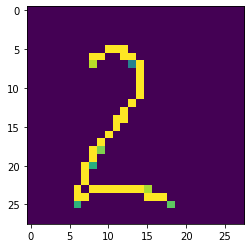

In [13]:
print(f'Prediction by Convolutional Neural Network Model Complete:\n{hl*3}\n\
    Model predicts that the integer \"{str(prediction)}\" was drawn,\n\
    Model attributes {probability} probability that this is accurate')

plt.imshow(image_array_0)
plt.show()

<h3 align=center>FLASK APP BELOW TESTED</h3>